In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal`

In [148]:
df = pd.read_csv('data/chbmit_preprocessed_data.csv')
df["Outcome"] = df.Outcome.astype("category")

In [149]:
fs = 256 #hz
bin_size=15 #sec
bins = np.repeat(np.arange(round(df.shape[0]/(fs*15))),fs*bin_size)

df = df[:len(bins)] 

df["bins"] = bins

In [150]:
select_channels=['C3-P3','FP2-F8','T7-FT9','FZ-CZ','bins','Outcome']
df_sub = df.loc[:,select_channels]

In [138]:
# single
df.groupby("bins").agg({"C3-P3":[np.mean,np.std,np.min,np.max]})

C3-P3                              
              mean       std      amin      amax
bins                                            
0    -2.920096e-07  0.000022 -0.000082  0.000075
1     2.573281e-07  0.000022 -0.000070  0.000078
2    -5.365865e-07  0.000026 -0.000086  0.000084
3     1.749044e-06  0.000036 -0.000164  0.000191
4    -2.253570e-06  0.000046 -0.000121  0.000182
...            ...       ...       ...       ...
541   1.010527e-06  0.000080 -0.000278  0.000251
542  -1.175362e-07  0.000078 -0.000291  0.000229
543   2.034930e-07  0.000081 -0.000240  0.000230
544   1.266365e-06  0.000074 -0.000277  0.000238
545  -5.853609e-07  0.000081 -0.000234  0.000271

[546 rows x 4 columns]

(0.0, 8000.0)

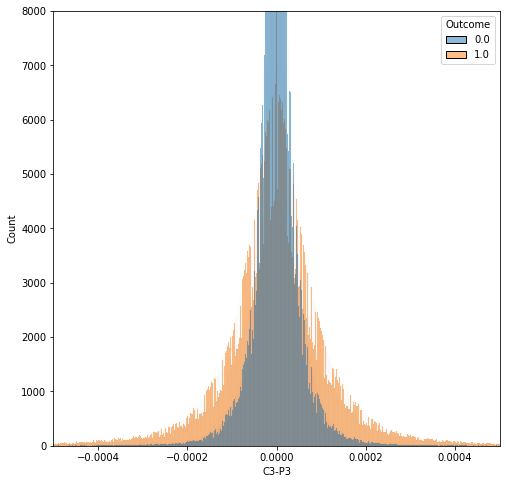

In [93]:
# showing a difference

plt.subplots(1,figsize=(8,8))
sns.histplot(df,x="C3-P3",hue="Outcome")
plt.xlim([-.0005,0.0005])
plt.ylim([0,8000])

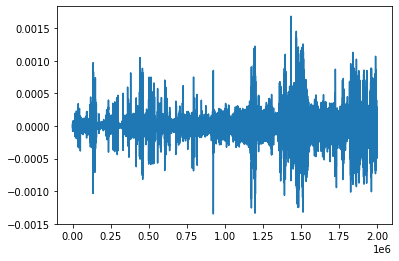

In [113]:
plt.plot(df.loc[1:2000000,"C3-P3"])

In [68]:
# start
dfi = df.query("Outcome ==1").reset_index()

dfi.shape

(1048575, 26)

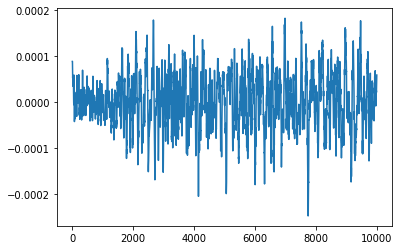

In [70]:
plt.plot(dfi.loc[1:10000,"C3-P3"])

# ML

In [203]:
#df_agg = df_sub.groupby(["Outcome","bins"]).agg([np.std,np.min,np.max])
df_agg = df_sub.groupby(["Outcome","bins"]).agg(['std','min','max'])


df_agg.columns = ["_".join(a) for a in df_agg.columns.to_flat_index()]
df_agg.reset_index(inplace=True)

In [256]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score,auc,roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score


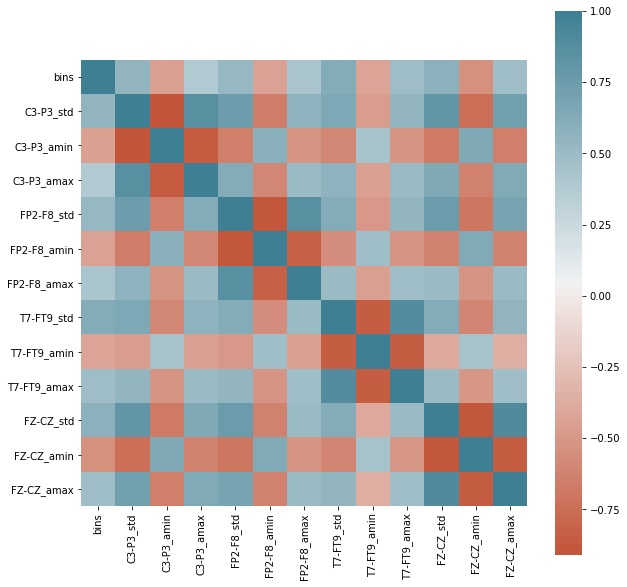

In [173]:
fig,ax = plt.subplots(1, figsize = (10,10))
ax = sns.heatmap(df_agg.corr(), ax = ax, cmap=sns.diverging_palette(20, 220, n=200), square = True)

In [211]:
# BIG DROP NEED TO LOOKINTO
df_agg = df_agg.dropna()

In [166]:
seed=42

In [212]:
X = df_agg.drop(columns=['Outcome','bins']).reset_index(drop=True)
Y = df_agg['Outcome'].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
print(f"Training size = {X_train.shape[0]}")
print(f"Testing size = {X_test.shape[0]}")

Training size = 437
Testing size = 110


In [214]:
rf = RandomForestClassifier(random_state = 1)
pipe = make_pipeline(StandardScaler(),rf)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(pipe, X_train, y_train.values.ravel(), cv=kfold)
rf_score = cv_score.mean()

print(f'RF K-fold Scores: {np.round(cv_score,3)}')
print(f'RF Average Score: {round(rf_score,3)}')

RF K-fold Scores: [0.864 0.795 0.886 0.955 0.841 0.773 0.773 0.907 0.93  0.837]
RF Average Score: 0.856


In [ ]:
rf_model = pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

RF Model Accuracy (on testing set): 0.9364


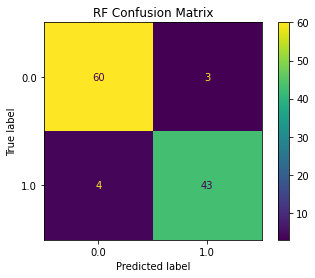

In [228]:
# built in confusion
disp = plot_confusion_matrix(rf_model, X_test, y_test)
disp.ax_.set_title('RF Confusion Matrix')

print(f'RF Model Accuracy (on testing set): {round(accuracy_score(y_test, y_pred),4)}')

In [258]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94        63
         1.0       0.93      0.91      0.92        47

    accuracy                           0.94       110
   macro avg       0.94      0.93      0.93       110
weighted avg       0.94      0.94      0.94       110



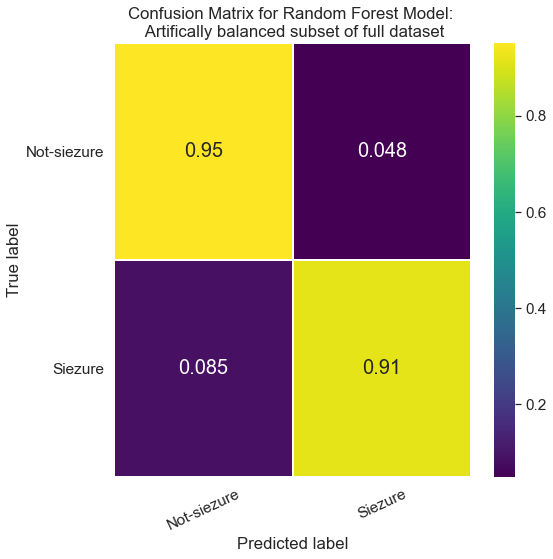

In [264]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.viridis, linewidths=0.2)

# Add labels to the plot
class_names = ['Not-siezure','Siezure']
tick_marks = np.arange(len(class_names)) + .5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model: \n Artifically balanced subset of full dataset')
plt.show()

NameError: name 'average_precision' is not defined

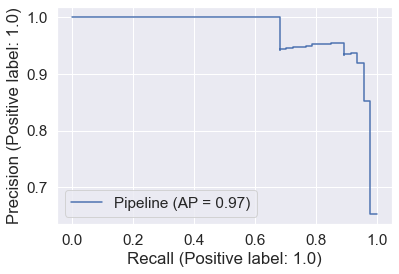

In [260]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(rf_model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))